<div class="dataset-header-v2__top-image-container"><img src="https://storage.googleapis.com/kaggle-datasets-images/131128/312839/f2a834dc8580f0788bea087e8d3a6dbe/dataset-cover.jpeg?t=2019-03-04-05-49-08" class="Header_CoverImg-sc-1431b7d ibFJYv"></div>

In [ ]:
!pip install -qq einops
!pip install -qq torchsummary

import os
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from torch import Tensor
from torch.utils.data import Subset

from PIL import Image
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

<h1 id="dataset" style="color:brown; background:black;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class RetinopathyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.img_paths = list(self.absolute_paths(path))
        self.transform = transform
        png_ext = '.png'
        self.paths = [p for p in self.img_paths if png_ext in p]
        self.df = pd.read_csv(path + 'train.csv')
        self.df = shuffle(self.df)
    
    def absolute_paths(self, directory):
        for dirpath,_,filenames in os.walk(directory):
            for f in filenames:
                yield os.path.abspath(os.path.join(dirpath, f))
                
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        id_code = self.df.iloc[idx].id_code
        diagnosis = self.df.iloc[idx].diagnosis
        
        img_path = [s for s in self.paths if id_code in s][0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, diagnosis

In [ ]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=224),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
path = '../input/diabetic-retinopathy-224x224-gaussian-filtered/'

rds_train = RetinopathyDataset(path, train_transform)
rds_val = RetinopathyDataset(path, val_transform)

In [ ]:
plt.imshow(rds_train[0][0].permute(1, 2, 0))

In [ ]:
train_idx, valid_idx = train_test_split(np.arange(len(rds_train)), shuffle=False,
                                                    test_size=0.3, random_state=42)

In [ ]:
train_subset = Subset(rds_train, train_idx)
valid_subset = Subset(rds_val, valid_idx)

In [ ]:
train_loader = DataLoader(train_subset, batch_size=8,
                          shuffle=True, num_workers=0)

valid_loader = DataLoader(valid_subset, batch_size=8,
                          shuffle=True, num_workers=0)

<h1 id="architecture" style="color:brown; background:black;"> 
    <center>Architecture
        <a class="anchor-link" href="#architecture" target="_self">¶</a>
    </center>
</h1>

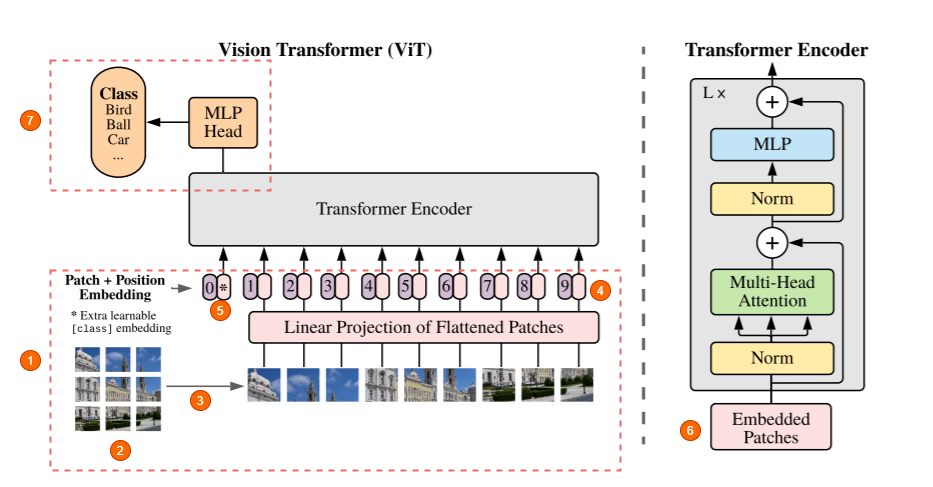

<h1 id="implementation" style="color:brown; background:black;"> 
    <center>Implementation
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h1>

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, 
                 emb_size: int=768, img_size: int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, 
                      kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(
                         torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=8, dropout: float=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 
                        "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        # batch, num_heads, query_len, key_len
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int=4, drop_p: float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 5,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

<h1 id="training" style="color:brown; background:black;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ViT().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
epochs = 100

epoch_losses = np.zeros((epochs, len(train_loader)))
epoch_accuracies = np.zeros((epochs, len(train_loader)))

epoch_val_losses = np.zeros((epochs, len(valid_loader)))
epoch_val_accuracies = np.zeros((epochs, len(valid_loader)))

for epoch in range(epochs):
    
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracies[epoch][i] = acc
        
        epoch_loss = loss / len(data)
        epoch_losses[epoch][i] = epoch_loss
        
    with torch.no_grad():

        for i, (data, label) in enumerate(valid_loader):
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output, label)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracies[epoch][i] = acc
            
            epoch_val_loss = val_loss / len(data)
            epoch_val_losses[epoch][i] = epoch_val_loss
           
    if((epoch+1) % 10 == 0):
        print("Epoch:{:3d}, loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}"
              .format(epoch, epoch_losses[epoch].mean(), 
                      epoch_accuracies[epoch].mean(), 
                      epoch_val_losses[epoch].mean(), 
                      epoch_val_accuracies[epoch].mean()))

In [ ]:
(output.argmax(dim=1) == label).float().mean()

<h1 id="analyze" style="color:brown; background:black;"> 
    <center>Analyze
        <a class="anchor-link" href="#analyze" target="_self">¶</a>
    </center>
</h1>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
axes[0,0].set_title('Training Losses', color='blue')
axes[0,0].plot(epoch_losses.mean(axis=1))
axes[0,0].axes.get_xaxis().set_visible(False)
axes[0,1].set_title('Validation Losses', color='blue')
axes[0,1].plot(epoch_val_losses.mean(axis=1))
axes[0,1].axes.get_xaxis().set_visible(False)
axes[1,0].set_title('Training Accuracy', color='orange')
axes[1,0].plot(epoch_accuracies.mean(axis=1), color='orange')
axes[1,0].axes.get_xaxis().set_visible(False)
axes[1,1].set_title('Validation Accuracy', color='orange')
axes[1,1].plot(epoch_val_accuracies.mean(axis=1), color='orange')
axes[1,1].axes.get_xaxis().set_visible(False)
fig.tight_layout()

<h1 id="predict" style="color:brown; background:black;"> 
    <center>Predict
        <a class="anchor-link" href="#predict" target="_self">¶</a>
    </center>
</h1>

In [ ]:
def predict(image, device):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
        
    label = model(image.to(device))
    label_max = torch.max(label, axis=1)[1].item()
    return label_max

In [ ]:
# try 10 images
for i in range(10):
    image, label = rds_val[i]
    
    predicted = predict(image, device)
    expected = label
    correct = expected==predicted
    
    print('{:2d}) Expected:{:1d} - Predicted:{:1d} - Correct:{}'
             .format(i+1, expected, predicted, correct))